## Gradient Boosting for Prediction and Inference

### Lesson 1
In this notebook we will walk through Decision Trees and Random Forests.  These methods serve as the foundations to Gradient Boosted Trees, and understanding them deeply is key to developing intuition around the use of Gradient Boosting.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Decision Trees

- "Similarity Principle" - two values of x that are "similar" should have similar predictions about y.
- For numeric predictors, similarity means that $|x_1 - x_2|$ is small
- For categorical predictors, less clear how to define similarity (more about this later)


### Example: Linear Regression
- Consider linear regression on a single variable.
- Model: $y = \alpha + \beta x$
- Similarity comes from the fact that the function is continuous
- Lines give an easily specified set of reasonable functions, that are governed by few (two) parameters

- Q: What is another class of functions that can be specified with few parameters?
- A: There are many, but in particular: step functions!
    - $f(x) = a \mbox{ if } x\leq c$
    - $f(x) = b \mbox{ if } x> c$

### Fitting a step function
- In linear regression, there is matrix algebra that lets you find the best $\alpha, \beta$ to minimze the mean squared error on a data set.
- For a step function, you just try every possible "split" $c$ and then choose $a$ and $b$ to be the means of the points on each side of the split respectively

In [2]:
np.random.seed(0)
npts=25
xvec = np.round(np.random.uniform(0,10, size=25), decimals = 2)
yvec = 2*(xvec<=7) + 6*(xvec>7) + np.round(np.random.normal(0,1,size=25), decimals=2)

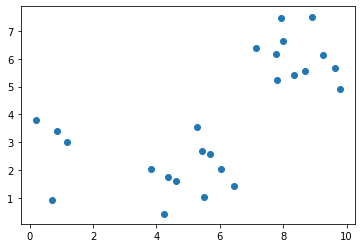

In [3]:
plt.scatter(xvec, yvec)

In [4]:
# Quick loop to try all split values

for split_val in np.unique(xvec)[:-1]:
    a_val = np.mean(yvec[xvec<=split_val])
    b_val = np.mean(yvec[xvec>split_val])
    error_1 = (yvec[xvec<=split_val] - a_val)**2
    error_2 = (yvec[xvec>split_val] - b_val)**2
    error = np.mean(np.concatenate((error_1, error_2)))
    print(split_val, np.round(a_val,decimals=3), 
          np.round(b_val, decimals=3), np.round(error,decimals=3))

0.2 3.79 3.898 4.675
0.71 2.355 4.028 4.469
0.87 2.703 4.056 4.482
1.18 2.778 4.107 4.438
3.83 2.632 4.21 4.277
4.24 2.267 4.408 3.839
4.38 2.194 4.555 3.552
4.61 2.121 4.728 3.196
5.29 2.279 4.802 3.208
5.45 2.319 4.944 3.022
5.49 2.203 5.223 2.428
5.68 2.233 5.427 2.13
6.03 2.218 5.71 1.631
6.46 2.161 6.099 0.855
7.15 2.443 6.071 1.516
7.78 2.676 6.059 2.039
7.81 2.826 6.164 2.251
7.92 3.083 5.979 2.985
7.99 3.271 5.868 3.444
8.33 3.379 5.956 3.612
8.7 3.481 6.06 3.782
8.92 3.665 5.577 4.289
9.26 3.773 5.29 4.506
9.64 3.852 4.91 4.632


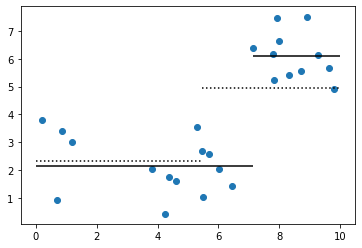

In [5]:
# Plot best split 
plt.scatter(xvec, yvec)
plt.hlines(y=2.16, xmin=0, xmax=7.15)
plt.hlines(y=6.09, xmin=7.15, xmax=10)
plt.hlines(y=2.319, xmin=0, xmax=5.45, linestyles='dotted')
plt.hlines(y=4.944, xmin=5.45, xmax=10, linestyles='dotted')

### Question 1: What about when I want multiple steps?
- Let $m$ be number of different x values
- To check every division into two steps takes $m$ evaluations
- To check every division into three steps takes $m^2$ evaluations
- etc....

### Question: What about when I have multiple variables?
- Again, to find the best step function with say 8 leaves and 4 variables would be very difficult

### Solution: Use a greedy approach
- Find the best split across all variables
- Repeat process on each side of split separately (using only data on that side of split)
- Stop according to some rules
- Note: This does not find the best possible tree!  For example, it may be that you get the best tree by choosing a "not-so-good" split first, but it enables better splits below.

### Question: What happens as I keep splitting more and more

### Parameters for decision tree algorithm
(I put the sklearn names below, other packages may vary in their naming)
- `max_depth`: don't split further when you've reached a certain depth
- `min_samples_split`: don't split if you have few data points at the node
- `min_samples_leaf`: don't split if it creates a node with few data points
- `criterion`: how to evaluate how "good" a split is.  Typically use mean_squared_error for regression and entropy for classification (though "gini" is also used as a quicker approximation to entropy).  In practice, the distinction between entropy and gini is usually not that important.

### Implementation details:
- Where should I put the split_value if there are no x values between 1.18 and 3.83 (but that is the best split)?
- In other words, for future values between 1.18 and 3.83, should they go "left" or "right"
- What about missing values?

## Random Forests: Motivating thought experiment
- In practice, it is rare to use a single decision tree as your model (though it does happen!)
- Imagine you build a decision tree, and at the root it is very close between two different variables as to which is the best to split on.
- The "best" tree $T_1$ gives a reasonable model. However, you also check what tree you would have built if you used the second-best split (at the root) (call it $T_2$).
- Then you average the predictions of $T_1$ and $T_2$ and find it does better than either tree alone
- You would like to expand this idea and build 1000 trees that are all "pretty good" and also different from one another.
- IDEA: inject some randomness into tree building process...

### Injecting Randomness
The random forest builds many decision trees independently.  Since the decision tree algorithm is deterministic, if you run it over and over again on the same dataset, you will just get the same tree over and over.

#### Randomness 1
Use different datasets each time.  Specifically, take a random sample of your data (how big? with or without replacement?).  This is called "bagging".  This means you can get different trees because the data looks different.
- This helps, but the trees end up still being pretty similar most of the time

#### Randomness 2
Only evaluate a subset of the predictors at each node.  For example, if you have 10 predictors, randomly choose 3 and only consider those.  This means the root splits (and subsequent splits) will be quite different from tree to tree.

Since each tree is a completely independent trial of this process, it is straightforward to parallelize.

### Parameters for Random Forest (in addition to Decision Tree)
- all the tree-specific parameters above
- `n_estimators`: Number of trees to fit
- `max_features`: How many (or what percentage) of the features to try at each node.

## Let's play with some data

Our first data set will contain games from the NBA.  We will play around with trying to predict the winner of the game from some team statistics.

In [6]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split

In [7]:
df_nba = pd.read_csv('data/games.csv')
df_nba.dropna(inplace=True)
df_nba.shape

(23096, 21)

In [8]:
df_nba.sample(5)

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
308,2020-01-13,21900596,Final,1610612758,1610612753,2019,1610612758,112.0,0.517,0.909,...,25.0,44.0,1610612753,114.0,0.435,0.833,0.310,17.0,46.0,0
11476,2006-11-08,20600058,Final,1610612761,1610612755,2006,1610612761,106.0,0.409,0.793,...,19.0,45.0,1610612755,104.0,0.494,0.750,0.250,22.0,53.0,1
14004,2004-12-27,20400399,Final,1610612757,1610612755,2004,1610612757,104.0,0.482,0.731,...,27.0,48.0,1610612755,111.0,0.446,0.731,0.435,28.0,41.0,0
7765,2009-03-10,20800954,Final,1610612746,1610612739,2008,1610612746,83.0,0.390,0.800,...,20.0,41.0,1610612739,87.0,0.390,0.800,0.150,16.0,46.0,0
13620,2005-02-17,20400781,Final,1610612756,1610612742,2004,1610612756,113.0,0.453,0.818,...,22.0,41.0,1610612742,119.0,0.536,0.913,0.533,19.0,44.0,0


In [9]:
df_nba.columns

Index(['GAME_DATE_EST', 'GAME_ID', 'GAME_STATUS_TEXT', 'HOME_TEAM_ID',
       'VISITOR_TEAM_ID', 'SEASON', 'TEAM_ID_home', 'PTS_home', 'FG_PCT_home',
       'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home', 'TEAM_ID_away',
       'PTS_away', 'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away',
       'REB_away', 'HOME_TEAM_WINS'],
      dtype='object')

In [10]:
feat_1 = ['FG_PCT_home','FT_PCT_home', 'FG_PCT_away', 'FT_PCT_away']
feat_2 = ['FG_PCT_home','FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home', 
        'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away']


In [11]:
X = df_nba.iloc[:,:-1]  # everything except winner
y = df_nba.HOME_TEAM_WINS 

In [12]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X,y,test_size = 2000, random_state=0)

In [13]:
X_train_full.columns

Index(['GAME_DATE_EST', 'GAME_ID', 'GAME_STATUS_TEXT', 'HOME_TEAM_ID',
       'VISITOR_TEAM_ID', 'SEASON', 'TEAM_ID_home', 'PTS_home', 'FG_PCT_home',
       'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home', 'TEAM_ID_away',
       'PTS_away', 'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away',
       'REB_away'],
      dtype='object')

In [14]:
n_train_pts = 2000
X_train_1 = X_train_full.iloc[:n_train_pts].loc[:, feat_1]
y_train_1 = y_train_full.iloc[:n_train_pts]
X_test_1 = X_test.loc[:, feat_1]

In [15]:
rf1 = RandomForestClassifier(n_estimators=1000)
rf1

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [16]:
rf1.fit(X_train_1, y_train_1)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [17]:
prob_preds_1 = rf1.predict_proba(X_test_1)[:,1]

In [18]:
log_loss(y_test, prob_preds_1), roc_auc_score(y_test, prob_preds_1)

(0.4449462833646558, 0.8687129991972706)

In [19]:
hard_preds_1 = (prob_preds_1 > .5).astype(int)

In [20]:
accuracy_score(y_test, hard_preds_1)

0.794

#### Now let's repeat with the bigger feature set

In [21]:
X_train_2 = X_train_full.iloc[:n_train_pts].loc[:, feat_2]
y_train_2 = y_train_full.iloc[:n_train_pts]
X_test_2 = X_test.loc[:, feat_2]

In [22]:
rf2 = RandomForestClassifier(n_estimators=1000)
rf2.fit(X_train_2, y_train_2)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [23]:
prob_preds_2 = rf2.predict_proba(X_test_2)[:,1]

In [24]:
log_loss(y_test, prob_preds_2), roc_auc_score(y_test, prob_preds_2)

(0.37299959595259247, 0.9146185572613552)

In [25]:
hard_preds_2 = (prob_preds_2>.5).astype(int)

In [26]:
accuracy_score(y_test, hard_preds_2)

0.838

## Exercise:
1. Train, Predict and Evaluate Random Forest models using feature sets 3 and 4 below.  Note that 'PTS_home' and 'PTS_away' represent the number of points scored by each team.
2. Which model does better?  Why?
3. What does this demonstrate about the limitations of the greedy tree-building process?
4. What does this demonstrate about the importance of feature engineering?  What feature could be created that would make the RF perform flawlessly?  Why couldn't the RF "figure it out" without that feature being made explicit?

In [27]:
feat_3 = ['FG_PCT_home','FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home', 
        'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away',
         'PTS_home', 'PTS_away']
feat_4 = ['PTS_home', 'PTS_away']

In [28]:
X_train_3 = X_train_full.iloc[:n_train_pts].loc[:, feat_3]
y_train_3 = y_train_full.iloc[:n_train_pts]
X_test_3 = X_test.loc[:, feat_3]

In [29]:
# ...

In [30]:
X_train_4 = X_train_full.iloc[:n_train_pts].loc[:, feat_4]
y_train_4 = y_train_full.iloc[:n_train_pts]
X_test_4 = X_test.loc[:, feat_4]

In [31]:
#...